In [697]:
import numpy as np
import pandas as pd
from pathlib import Path
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import hvplot.pandas
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

In [698]:
from os import listdir
from os.path import isfile

In [699]:
from sklearn.linear_model import LinearRegression

In [700]:
dir = "../Resources/"

In [701]:
# Read all the files from the resources and put them in a list
all_files = [x for x in listdir(dir) if (".xlsx" in x or ".csv" in x)]
all_files

['corn.xlsx',
 'feeder_cattle.xlsx',
 'live_cattle.xlsx',
 'soybean_meal.xlsx',
 'lean_hogs.xlsx',
 'soybeans.xlsx']

In [702]:
all_df = pd.DataFrame()
for x in all_files:
    a = x.replace(".xlsx", "")
    df = pd.read_excel(dir+x)
    df["name"] = a
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.set_index("Date")
    df = df.sort_index()
    df = df.dropna()
    df = df[df['Volume'] != 0.0]
    df.drop(['Volume'], axis=1, inplace=True)
    if a == "corn":
        corn = df
        all_df["corn"] = corn["Price"]
    elif a == "live_cattle":
        live_cattle = df
        all_df["live_cattle"] = live_cattle["Price"]
    elif a == "feeder_cattle":
        feeder_cattle = df
        all_df["feeder_cattle"] = feeder_cattle["Price"]
    elif a == "soybean_meal":
        soybean = df
        all_df["soybean_meal"] = soybean["Price"]
    elif a == "lean_hogs":
        hog = df
        all_df["hog"] = hog["Price"]

In [703]:
all_df['hog_delta_5'] = all_df["hog"].shift(105)
all_df['corn_delta_5'] = all_df["corn"].shift(105)
all_df['soybean_meal_delta_5'] = all_df["soybean_meal"].shift(105)
all_df = all_df.dropna()
# Crush Margin = 2 x CME lean hog futures price (5 months
# from placement) – 0.5 x CME lean hog futures price (5
# months from placement) – 10 x CME corn futures price (at
# placement) – 0.075 x CME soybean meal futures price (at
# placement)
# GFM t= 2.05 * LH t - WP t-5-(10 * C t-5)-(0.075 * SM t-5)
all_df["GFM"] = (2.05*all_df["hog"]) - (all_df['hog_delta_5']*0.5) - (10 * all_df['corn_delta_5']) - (0.075 * all_df['soybean_meal_delta_5'])
# all_df = all_df.drop(columns=['feeder_cattle', 'live_cattle', 'hog_delta_5', 'corn_delta_5', 'soybean_meal_delta_5'])
all_df.head(10)

,corn,feeder_cattle,live_cattle,soybean_meal,hog,hog_delta_5,corn_delta_5,soybean_meal_delta_5,GFM
Date,,,,,,,,,
2001-06-04,2.1500,91.450,76.200,151.9,52.075,47.500,2.6175,176.3,43.60625
2001-06-05,2.1425,91.500,76.275,152.2,51.575,47.800,2.5825,176.4,42.77375
2001-06-06,2.1725,91.350,75.975,154.1,51.425,47.150,2.6100,175.2,42.60625
2001-06-07,2.1700,91.150,75.750,153.8,51.600,48.000,2.6100,173.8,42.64500
2001-06-08,2.1550,91.475,75.950,155.7,52.675,48.000,2.5800,171.7,45.30625
2001-06-11,2.1725,91.475,75.925,156.8,53.375,48.300,2.5800,172.3,46.54625
2001-06-12,2.1575,91.250,75.550,158.6,53.525,48.275,2.5925,174.2,46.59875
2001-06-13,2.1525,91.125,75.575,157.7,53.600,47.800,2.6150,172.9,46.86250
2001-06-14,2.1350,90.850,75.175,156.9,52.925,47.875,2.5625,170.0,46.18375


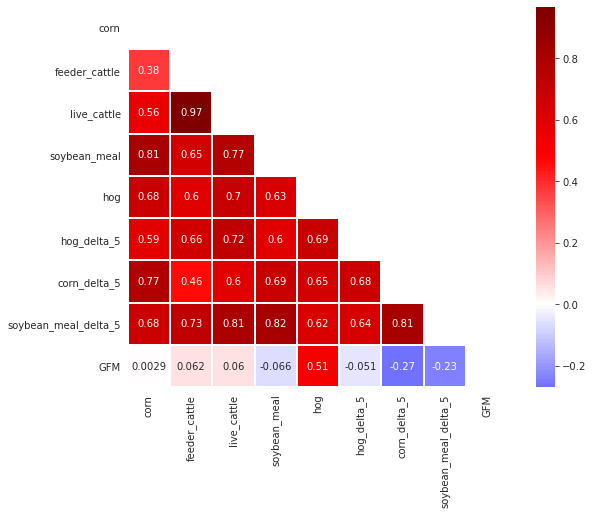

In [704]:
all_df = all_df.dropna()
corrM = all_df.corr()

mask = np.zeros_like(corrM)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(10,7))
    ax = sns.heatmap(corrM, mask=mask, center=0, annot=True, square=True, linewidths=1, cmap="seismic")

In [705]:
all_df.hvplot.line(xlabel="Time", ylabel="Price")

:NdOverlay   [Variable]
   :Curve   [Date]   (value)

In [706]:
def window_data(df, window, feature_col_number, target_col_number):
    X = []
    y = []
    for i in range(len(df) - window - 1):
        features = df.iloc[i:(i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)


def custom_ts_multi_data_prep(dataset, target, start, end, window, horizon):
    X = []
    y = []
    start = start + window
    if end is None:
        end = len(dataset) - horizon
    for i in range(start, end):
        indices = range(i-window, i)
        X.append(dataset[indices])
        indicey = range(i+1, i+1+horizon)
        y.append(target[indicey])
    return np.array(X), np.array(y) 

In [707]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf 

scaler = MinMaxScaler()

X_data = scaler.fit_transform(all_df[['corn', 'soybean_meal', 'GFM']])
Y_data = scaler.fit_transform(all_df[['hog']]) 

In [709]:
hist_window = 48
horizon = 10
TRAIN_SPLIT = 2500
x_train, y_train = custom_ts_multi_data_prep(X_data, Y_data, 0, TRAIN_SPLIT, hist_window, horizon)
x_vali, y_vali = custom_ts_multi_data_prep(X_data, Y_data, TRAIN_SPLIT, None, hist_window, horizon)

(2452, 48, 3)
(2452, 10, 1)
(1976, 48, 3)
(1976, 10, 1)


In [710]:
batch_size = 256
buffer_size = 150
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.cache().shuffle(buffer_size).batch(batch_size).repeat()
val_data = tf.data.Dataset.from_tensor_slices((x_vali, y_vali))
val_data = val_data.batch(batch_size).repeat() 

<RepeatDataset shapes: ((None, 48, 3), (None, 10, 1)), types: (tf.float64, tf.float64)>
<RepeatDataset shapes: ((None, 48, 3), (None, 10, 1)), types: (tf.float64, tf.float64)>


In [711]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Activation
from tensorflow.keras import metrics

In [712]:
lstm_model = tf.keras.models.Sequential([
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True), 
                                input_shape=x_train.shape[-2:]),
     tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
     tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Dropout(0.25),
     tf.keras.layers.Dense(units=horizon),
 ])
lstm_model.compile(optimizer="adam", loss="mean_squared_error")
lstm_model.summary() 

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_22 (Bidirectio (None, 48, 400)           326400    
_________________________________________________________________
dense_57 (Dense)             (None, 48, 20)            8020      
_________________________________________________________________
bidirectional_23 (Bidirectio (None, 300)               205200    
_________________________________________________________________
dense_58 (Dense)             (None, 20)                6020      
_________________________________________________________________
dense_59 (Dense)             (None, 20)                420       
_________________________________________________________________
dropout_50 (Dropout)         (None, 20)                0         
_________________________________________________________________
dense_60 (Dense)             (None, 10)              

In [715]:
model_path = 'Bidirectional_LSTM_Multivariate.h5'
early_stopings = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='min')
checkpoint =  tf.keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, mode='min', verbose=0)
callbacks=[early_stopings,checkpoint] 
epochs = 30
batch_size = 64
lstm_model.fit(train_data, epochs=epochs, steps_per_epoch=100, validation_data=val_data, validation_steps=50, verbose=1, callbacks=callbacks)

Epoch 1/30
100/100 [==============================] - 54s 499ms/step - loss: 0.0518 - val_loss: 0.0195
Epoch 2/30
100/100 [==============================] - 57s 572ms/step - loss: 0.0248 - val_loss: 0.0153
Epoch 3/30
100/100 [==============================] - 57s 571ms/step - loss: 0.0185 - val_loss: 0.0181
Epoch 4/30
100/100 [==============================] - 56s 560ms/step - loss: 0.0152 - val_loss: 0.0166
Epoch 5/30
100/100 [==============================] - 57s 575ms/step - loss: 0.0142 - val_loss: 0.0138
Epoch 6/30
100/100 [==============================] - 58s 578ms/step - loss: 0.0115 - val_loss: 0.0121
Epoch 7/30
100/100 [==============================] - 79s 794ms/step - loss: 0.0113 - val_loss: 0.0132
Epoch 8/30
100/100 [==============================] - 64s 644ms/step - loss: 0.0101 - val_loss: 0.0135
Epoch 9/30
100/100 [==============================] - 68s 676ms/step - loss: 0.0093 - val_loss: 0.0120
Epoch 10/30
100/100 [==============================] - 61s 607ms/step - l

In [716]:
lstm_model.evaluate(x_vali, y_vali, verbose=0)

0.009349290281534195

In [717]:
predicted = lstm_model.predict(x_vali)
val_rescaled = y_vali.reshape(y_vali.shape[0], y_vali.shape[1])

(1976, 10)
(1976, 10)
[[0.61035985 0.6148553  0.6098227  ... 0.6062007  0.61155    0.6073764 ]
 [0.6143254  0.6189188  0.6138341  ... 0.60995656 0.6155648  0.6109057 ]
 [0.6168529  0.62154365 0.61648566 ... 0.6124684  0.61790156 0.61293465]
 ...
 [0.570871   0.5744817  0.57079935 ... 0.5689636  0.57271326 0.57035404]
 [0.574461   0.578061   0.57414085 ... 0.5721274  0.57661855 0.57431144]
 [0.57078236 0.57411706 0.5705428  ... 0.56834805 0.57317775 0.5706471 ]]
[[0.68787346 0.70790861 0.69876977 ... 0.66467487 0.67381371 0.68541301]
 [0.70790861 0.69876977 0.69068541 ... 0.67381371 0.68541301 0.69209139]
 [0.69876977 0.69068541 0.69068541 ... 0.68541301 0.69209139 0.68646749]
 ...
 [0.6056239  0.58629174 0.54657293 ... 0.57469244 0.58699473 0.58804921]
 [0.58629174 0.54657293 0.5483304  ... 0.58699473 0.58804921 0.56133568]
 [0.54657293 0.5483304  0.56063269 ... 0.58804921 0.56133568 0.58523726]]


In [718]:
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(val_rescaled)

In [719]:
metric = metrics.Accuracy()
metric.update_state(real_prices,predicted_prices)
metric.result().numpy()

[[83.25  84.675 84.025 ... 81.6   82.25  83.075]
 [84.675 84.025 83.45  ... 82.25  83.075 83.55 ]
 [84.025 83.45  83.45  ... 83.075 83.55  83.15 ]
 ...
 [77.4   76.025 73.2   ... 75.2   76.075 76.15 ]
 [76.025 73.2   73.325 ... 76.075 76.15  74.25 ]
 [73.2   73.325 74.2   ... 76.15  74.25  75.95 ]]
[[77.73685  78.05658  77.69864  ... 77.441025 77.821495 77.52465 ]
 [78.01889  78.3456   77.983955 ... 77.70816  78.10705  77.77567 ]
 [78.19866  78.53229  78.17255  ... 77.88682  78.27325  77.91998 ]
 ...
 [74.9282   75.18501  74.9231   ... 74.79254  75.05923  74.89143 ]
 [75.18354  75.43959  75.160774 ... 75.01756  75.33699  75.172905]
 [74.9219   75.15907  74.904854 ... 74.74876  75.09227  74.91228 ]]


0.0

In [720]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(real_prices, predicted_prices))

47.29586417800032


In [734]:
hogs = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel(),
}) 
hogs.head()

,Real,Predicted
0,83.250,77.736847
1,84.675,78.056580
2,84.025,77.698639
3,83.450,77.717796
4,83.450,77.766907


In [735]:
hogs.hvplot.line(xlabel="Date", ylabel="Price")

:NdOverlay   [Variable]
   :Curve   [index]   (value)

In [723]:
forecast_out = 3
all_df['prediction'] = all_df[['hog']].shift(-forecast_out)
X = np.array(all_df['corn']).reshape(-1,1)
X = X[:-forecast_out]
y = np.array(all_df['prediction'])
y = y[:-forecast_out]

In [736]:
reg = RandomForestRegressor(n_estimators = 10, max_depth =100, random_state = 5)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state = 10)
reg.fit(X_train, y_train)
print("Performance (R^2): ", reg.score(X_test, y_test))

Performance (R^2):  0.4248971593949822
